In [1]:
from hmmlearn.hmm import GaussianHMM
import os
import pandas as pd
import numpy as np
import collections
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import MonthLocator

Let's fix some parameters

In [2]:
start_date = datetime.strptime('2016-01-11', '%Y-%m-%d')
end_date = datetime.strptime('2016-03-11', '%Y-%m-%d')
start_date_sample = datetime.strptime('2016-03-12', '%Y-%m-%d')
end_date_sample = datetime.strptime('2016-05-27', '%Y-%m-%d')

energy_data = os.path.abspath('datasets/energy_data/energydata_complete.csv')

Let's declare some utility functions that will be useful later.

In [3]:
from hmmlearn.base import ConvergenceMonitor

class HistoryMonitor(ConvergenceMonitor):
    def __init__(self, tol, n_iter, verbose):
        super().__init__(tol, n_iter, verbose)
        self.custom_history = []
 
    def report(self, logprob):
        self.custom_history.append(logprob)
        super().report(logprob)

In [4]:
def bic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    bic = np.log(len(X))*k - 2*likelihood_fn(X)
    return bic

<h2>Appliances consumptions</h2>

In [5]:
# take energy consumption of appliances
appliances = pd.read_csv(energy_data, header=0, index_col=0, parse_dates=True, usecols=[0, 1])

appliances_TR = appliances.loc[start_date:end_date]
appliances_TS = appliances.loc[start_date_sample:end_date_sample]
scores = collections.defaultdict(list)
bic_scores = collections.defaultdict(list)

print(appliances_TR.head())
print(appliances_TR.describe())

                     Appliances
date                           
2016-01-11 17:00:00          60
2016-01-11 17:10:00          60
2016-01-11 17:20:00          50
2016-01-11 17:30:00          50
2016-01-11 17:40:00          60
        Appliances
count  8539.000000
mean     98.101651
std     109.061956
min      10.000000
25%      50.000000
50%      60.000000
75%     100.000000
max    1080.000000


In [6]:
# setup the number of hidden states for which evaluate our models
K_MIN = 2
K_MAX = 8
# initialize best score for model selection
best_score = float('inf')

In [7]:
for k in range(K_MIN, K_MAX):
    # create the HMMs and fit them to data
    model = GaussianHMM(n_components=k, n_iter=1000)
    model.monitor_ = HistoryMonitor(model.monitor_.tol,
                                  model.monitor_.n_iter,
                                  model.monitor_.verbose)
    model.fit(appliances_TR)
    scores[model.n_components].append(model.score(appliances_TR))
    # print("model.score", model.score(appliances_TR))  # log likelihood of the model
    
    # let's compare our log likelihood with the BIC standard
    free_parameters = 2*(model.n_components) + model.n_components*(model.n_components-1) + (model.n_components-1)
    bic_curr = bic_general(model.score, free_parameters, appliances_TR)
    bic_scores[model.n_components].append(bic_curr)
    # print("BIC: ", model.n_components, " ", bic_curr)
    
    # select the best model
    if (bic_curr < best_score):
        best_score = bic_curr
        appliances_model = model

In [8]:
print("Best model has " + str(appliances_model.n_components) + " hidden states")

Best model has 7 hidden states


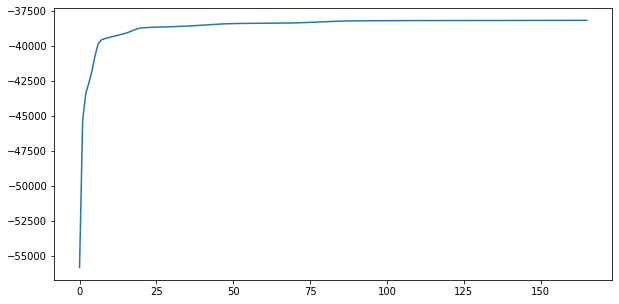

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(appliances_model.monitor_.custom_history)
plt.show()

In [10]:
print("EMalgorithm converges quickly - " + str(appliances_model.monitor_.iter) + " iterations")

EMalgorithm converges quickly - 166 iterations


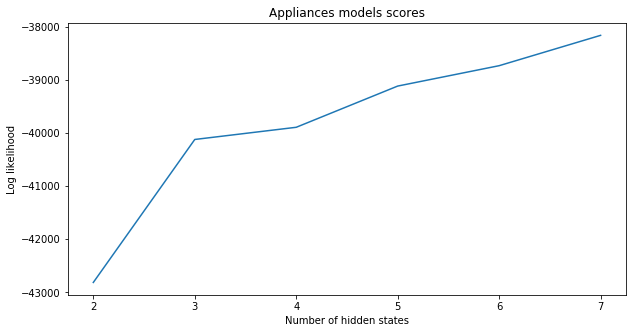

In [11]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of hidden states")
plt.ylabel("Log likelihood")
plt.title("Appliances models scores")
plt.show()

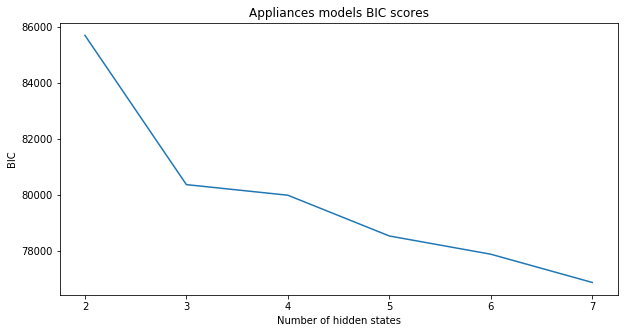

In [12]:
lists = sorted(bic_scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of hidden states")
plt.ylabel("BIC")
plt.title("Appliances models BIC scores")
plt.show()

In [13]:
# Decode the optimal sequence of internal hidden state (Viterbi)
# The internal state of the model only determines the probability distribution of the observed variables
a_hidden_states = appliances_model.predict(appliances_TR)    

In [14]:
print("Transition matrix")
appliances_model.transmat_

Transition matrix


array([[7.95606781e-001, 6.75253874e-003, 9.71328227e-002,
        1.99761993e-002, 1.29511661e-091, 7.34451780e-003,
        7.31871401e-002],
       [1.07623005e-003, 8.50375689e-001, 1.08869151e-002,
        4.50936707e-004, 8.07156364e-002, 4.89458486e-002,
        7.54874437e-003],
       [5.98977981e-002, 2.18756899e-002, 7.42059692e-001,
        4.18104237e-012, 3.83588543e-017, 1.10096471e-001,
        6.60703491e-002],
       [5.30669925e-002, 2.82752161e-087, 2.14779267e-003,
        6.23273393e-001, 2.09711952e-181, 5.04353259e-061,
        3.21511822e-001],
       [1.40481766e-009, 3.24880132e-001, 1.69415619e-016,
        2.30898767e-108, 6.38622397e-001, 2.42940790e-002,
        1.22033898e-002],
       [1.32753588e-005, 1.20392947e-001, 5.55249974e-002,
        5.20679979e-003, 1.18723224e-002, 7.58834415e-001,
        4.81552428e-002],
       [1.08705586e-001, 5.95839771e-003, 8.67855930e-002,
        8.01283506e-002, 1.21778638e-046, 6.78428669e-002,
        6.50579206

In [15]:
print("Means and vars of each hidden state")
for i in range(appliances_model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", appliances_model.means_[i])
    print("var = ", np.diag(appliances_model.covars_[i]))

Means and vars of each hidden state
0th hidden state
mean =  [113.85745824]
var =  [288.33922662]
1th hidden state
mean =  [45.87473605]
var =  [40.59254154]
2th hidden state
mean =  [83.23063633]
var =  [114.93316993]
3th hidden state
mean =  [510.05729527]
var =  [22066.6409928]
4th hidden state
mean =  [26.3791554]
var =  [36.07972488]
5th hidden state
mean =  [60.13515132]
var =  [66.60277765]
6th hidden state
mean =  [258.50194262]
var =  [8598.95991585]


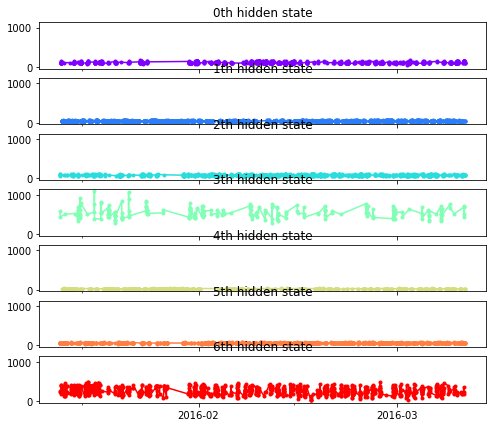

In [16]:
pd.plotting.register_matplotlib_converters()

fig, axs = plt.subplots(appliances_model.n_components, sharex=True, sharey=True, figsize=(8, 7))
colours = cm.rainbow(np.linspace(0, 1, appliances_model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = a_hidden_states == i
    ax.plot(appliances_TR[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))    
plt.plot()
plt.show()

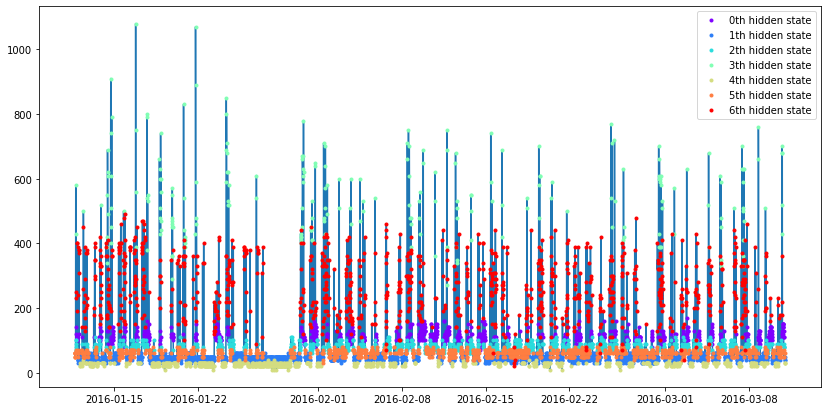

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(appliances_TR)
ax = list(range(0, len(appliances_TR)))
colours = cm.rainbow(np.linspace(0, 1, appliances_model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = a_hidden_states == i
    plt.plot(appliances_TR[mask], ".", c=colour, label="{0}th hidden state".format(i))
plt.legend(loc='best')
plt.show()

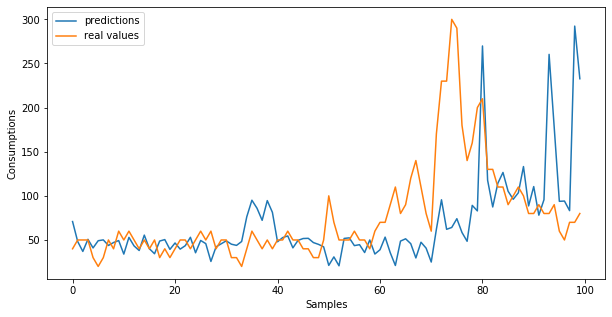

In [74]:
N = 100

# Generate samples(visible, hidden)
X, Z = appliances_model.sample(N)

# Compare the sampled elements wrt ground truth data
plt.figure(figsize=(10, 5))
plt.plot(X, label='predictions')
plt.plot(appliances_TS.to_numpy()[0:N], label='real values')
plt.xlabel("Samples")
plt.ylabel("Consumptions")
plt.legend()
plt.show()

Peaks are well determined by the predicted samples

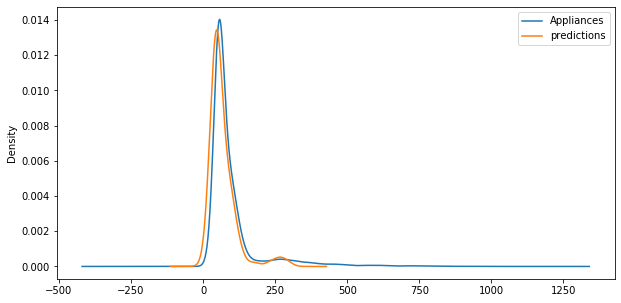

In [75]:
X = pd.DataFrame(X, columns=['predictions'])
frames = [appliances_TS, X]
df = pd.concat(frames, sort=True)
ax = df.plot.kde(figsize=(10, 5))

As a matter of facts, the sampled sequence has roughly the same density distribution of the test dataset

______
<h2>Lights consumptions</h2>

In [20]:
# take energy consumption of lights
lights = pd.read_csv(energy_data, header=0, index_col=0, parse_dates=True, usecols=[0, 2])

lights_TR = lights.loc[start_date:end_date]
lights_TS = lights.loc[start_date_sample:end_date_sample]
scores = collections.defaultdict(list)
bic_scores = collections.defaultdict(list)

print(lights_TR.head())
print(lights_TR.describe())
print(lights_TS.head())
print(lights_TS.describe())

                     lights
date                       
2016-01-11 17:00:00      30
2016-01-11 17:10:00      30
2016-01-11 17:20:00      30
2016-01-11 17:30:00      40
2016-01-11 17:40:00      40
            lights
count  8539.000000
mean      5.541633
std       9.407176
min       0.000000
25%       0.000000
50%       0.000000
75%      10.000000
max      70.000000
                     lights
date                       
2016-03-12 00:00:00       0
2016-03-12 00:10:00       0
2016-03-12 00:20:00       0
2016-03-12 00:30:00       0
2016-03-12 00:40:00       0
             lights
count  10945.000000
mean       2.485153
std        6.321982
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       50.000000


In [21]:
# setup the number of hidden states for which evaluate our models
K_MIN = 2
K_MAX = 6

# initialize best score for model selection
best_score = float('inf')

In [22]:
for k in range(K_MIN, K_MAX):
    # create the HMMs and fit them to data
    model = GaussianHMM(n_components=k, n_iter=1000)
    model.monitor_ = HistoryMonitor(model.monitor_.tol,
                                  model.monitor_.n_iter,
                                  model.monitor_.verbose)
    model.fit(lights_TR)
    scores[model.n_components].append(model.score(lights_TR))
    # print("model.score", model.score(lights_TR))  # log likelihood of the model
    
    # let's compare our log likelihood with the BIC standard
    free_parameters = 2*(model.n_components) + model.n_components*(model.n_components-1) + (model.n_components-1)
    bic_curr = bic_general(model.score, free_parameters, lights_TR)
    bic_scores[model.n_components].append(bic_curr)
    # print("BIC: ", model.n_components, " ", bic_curr)
    
    # select the best model
    if (bic_curr < best_score):
        best_score = bic_curr
        lights_model = model

In [23]:
print("Best model has " + str(lights_model.n_components) + " hidden states")

Best model has 5 hidden states


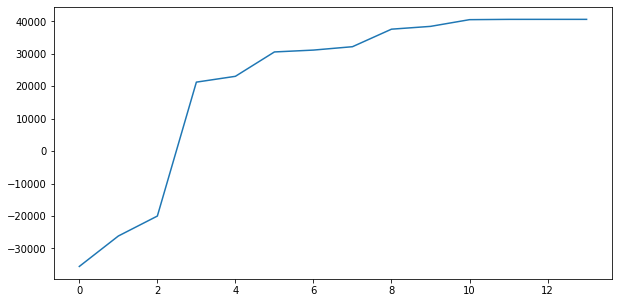

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(lights_model.monitor_.custom_history)
plt.show()

In [25]:
print("EM algorithm converges quickly - " + str(lights_model.monitor_.iter) + " iterations")

EM algorithm converges quickly - 14 iterations


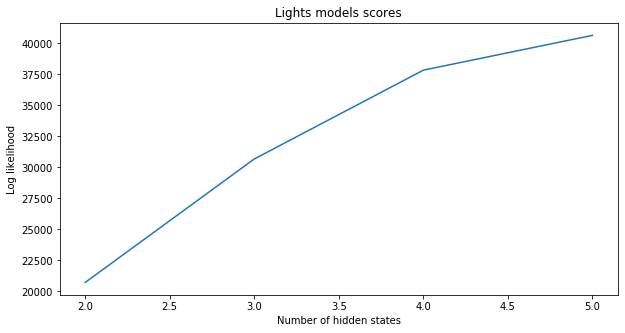

In [26]:
lists = sorted(scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of hidden states")
plt.ylabel("Log likelihood")
plt.title("Lights models scores")
plt.show()

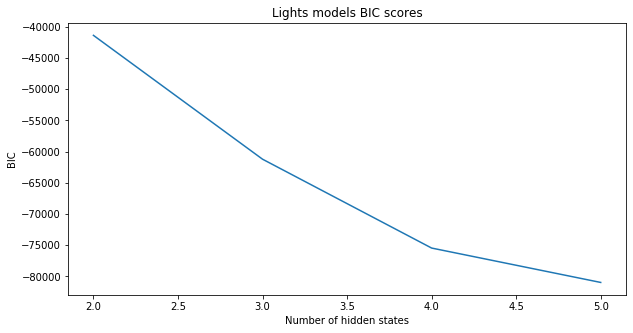

In [27]:
lists = sorted(bic_scores.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel("Number of hidden states")
plt.ylabel("BIC")
plt.title("Lights models BIC scores")
plt.show()

In [28]:
# Decode the optimal sequence of internal hidden state (Viterbi)
# The internal state of the model only determines the probability distribution of the observed variables
l_hidden_states = lights_model.predict(lights_TR)   

In [29]:
print("Transition matrix")
lights_model.transmat_

Transition matrix


array([[9.06897142e-01, 7.87266814e-03, 8.23207257e-02, 1.71152812e-04,
        2.73831151e-03],
       [5.00510727e-02, 5.22982637e-01, 1.74668029e-01, 1.22577478e-02,
        2.40040513e-01],
       [3.93841167e-01, 1.36952998e-01, 4.42463533e-01, 3.24166464e-03,
        2.35006369e-02],
       [1.21940038e-02, 1.09747376e-01, 7.31658034e-02, 4.14716654e-01,
        3.90176162e-01],
       [2.25004583e-02, 6.07512842e-01, 7.50010505e-02, 7.74963366e-02,
        2.17489312e-01]])

In [30]:
print("Means and vars of each hidden state")
for i in range(lights_model.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", lights_model.means_[i])
    print("var = ", np.diag(lights_model.covars_[i]))

Means and vars of each hidden state
0th hidden state
mean =  [0.]
var =  [1.71115674e-06]
1th hidden state
mean =  [20.]
var =  [1.02145045e-05]
2th hidden state
mean =  [10.]
var =  [8.10372771e-06]
3th hidden state
mean =  [41.46217072]
var =  [22.26063884]
4th hidden state
mean =  [30.]
var =  [2.50005544e-05]


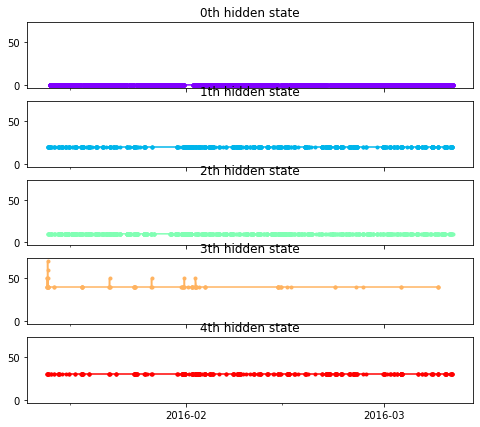

In [31]:
fig, axs = plt.subplots(lights_model.n_components, sharex=True, sharey=True, figsize=(8, 7))
colours = cm.rainbow(np.linspace(0, 1, lights_model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = l_hidden_states == i
    ax.plot(lights_TR[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_minor_locator(MonthLocator(bymonthday=15))    
plt.plot()
plt.show()

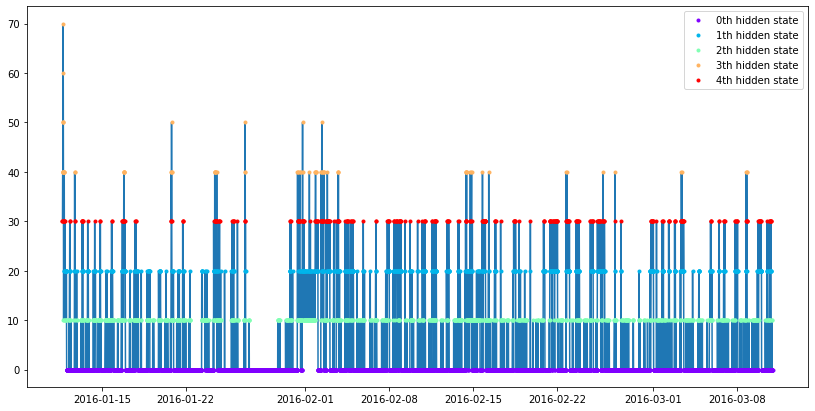

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(lights_TR)
ax = list(range(0, len(lights_TR)))
colours = cm.rainbow(np.linspace(0, 1, lights_model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    mask = l_hidden_states == i
    plt.plot(lights_TR[mask], ".", c=colour, label="{0}th hidden state".format(i))
plt.legend(loc='best')
plt.show()

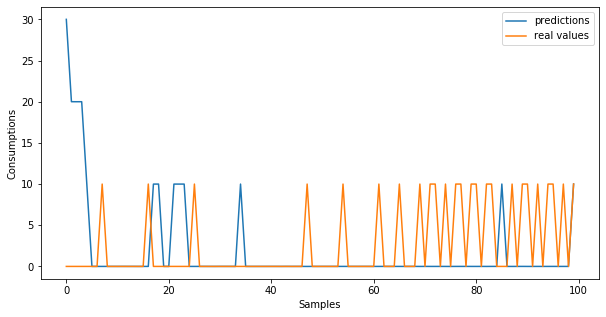

In [71]:
N = 100

# Generate samples(visible, hidden)
X, Z = lights_model.sample(N)

# Compare the sampled elements wrt ground truth data
plt.figure(figsize=(10, 5))
plt.plot(X, label='predictions')
plt.plot(lights_TS.to_numpy()[0:N], label='real values')
plt.xlabel("Samples")
plt.ylabel("Consumptions")
plt.legend()
plt.show()

Day/night cycle is well predicted by generated samples

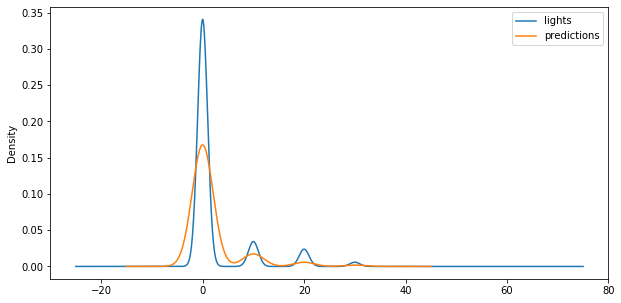

In [72]:
X = pd.DataFrame(X, columns=['predictions'])
frames = [lights_TS, X]
df = pd.concat(frames, sort=True)
ax = df.plot.kde(figsize=(10, 5))

___